In [23]:
import os
print(os.listdir("/kaggle/input/"))

['nationalholidaysindia', 'delhi-weather-data', 'electric-power-consumption-data-set', 'delhi-5-minute-electricity-demand-for-forecasting']


In [32]:
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

INPUT_DIR = f"/kaggle/input/grid-forecast-model-delhi-energy-consumption"

print(f"Attempting to load files from: {INPUT_DIR}")

try:
    electricity_cleaned = pd.read_pickle(f"{INPUT_DIR}electricity_cleaned.pkl")
    print("Cleaned data loaded successfully: 'electricity_cleaned'")
except Exception as e:
    print(f"Error loading cleaned data: {e}")

try:
    with open(f"{INPUT_DIR}lgb_model.pkl", 'rb') as f:
        lgb_model = pickle.load(f)
    print("LGBM model loaded successfully: 'lgb_model'")
except Exception as e:
    print(f"Error loading LGBM model: {e}")

try:
    lstm_model = load_model(f"{INPUT_DIR}lstm_model.h5") 
    print("LSTM model loaded successfully: 'lstm_model'")
except Exception as e:
    print(f"Error loading LSTM model: {e}")

Attempting to load files from: /kaggle/input/grid-forecast-model-delhi-energy-consumption
Error loading cleaned data: [Errno 2] No such file or directory: '/kaggle/input/grid-forecast-model-delhi-energy-consumptionelectricity_cleaned.pkl'
Error loading LGBM model: [Errno 2] No such file or directory: '/kaggle/input/grid-forecast-model-delhi-energy-consumptionlgb_model.pkl'
Error loading LSTM model: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/input/grid-forecast-model-delhi-energy-consumptionlstm_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [33]:
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

NOTEBOOK_SLUG = "grid-forecast-model-delhi-energy-consumption"
INPUT_DIR = f"/kaggle/input/{NOTEBOOK_SLUG}/"

print(f"Attempting final load from: {INPUT_DIR}")

try:
    electricity_cleaned = pd.read_pickle(f"{INPUT_DIR}electricity_cleaned.pkl")
    print("Cleaned data loaded successfully: 'electricity_cleaned'")
except Exception as e:
    print(f"FAILED to load cleaned data. Final error check: {e}")


Attempting final load from: /kaggle/input/grid-forecast-model-delhi-energy-consumption/
Cleaned data loaded successfully: 'electricity_cleaned'


In [66]:
INPUT_DIR = f"/kaggle/input/pkl-files/"

print(f"Attempting model load from: {INPUT_DIR}")

try:
    with open(f"{INPUT_DIR}lgb_model.pkl", 'rb') as f:
        lgb_model = pickle.load(f)
    print("LGBM model loaded successfully: 'lgb_model'")
except Exception as e:
    print(f"Error loading LGBM model: {e}")

try:
    lstm_model = load_model(f"{INPUT_DIR}lstm_model.h5")
    print("LSTM model loaded successfully: 'lstm_model'")
except Exception as e:
    print(f"Error loading LSTM model: {e}")

Attempting model load from: /kaggle/input/pkl-files/
LGBM model loaded successfully: 'lgb_model'
Error loading LSTM model: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}


In [50]:
from tensorflow.keras.metrics import MeanSquaredError

NOTEBOOK_SLUG = "pkl-files" 
INPUT_DIR = f"/kaggle/input/{NOTEBOOK_SLUG}/"

try:
    custom_objects = {
        'mse': 'mse', # Try resolving as a string first
        'MeanSquaredError': MeanSquaredError
    }

    lstm_model = load_model(
        f"{INPUT_DIR}lstm_model.h5", 
        custom_objects=custom_objects,
        compile=False
    )
    print("LSTM model loaded successfully: 'lstm_model'")
    
except Exception as e:
    print(f"Error loading LSTM model: {e}")

LSTM model loaded successfully: 'lstm_model'


In [51]:
# Calculate absolute percentage errors
abs_perc_error = np.abs((electricity['demand_mw'].values - pred_lgb_test[:len(electricity)]) / electricity['demand_mw'].values) * 100

# Compute percentiles
percentiles = [50, 75, 90, 95, 99]
perc_values = np.percentile(abs_perc_error, percentiles)
print("--- Absolute Percentage Error Percentiles ---")
for p, val in zip(percentiles, perc_values):
    print(f"{p}th percentile absolute percentage error: {val:.2f}%")

electricity['abs_perc_error'] = abs_perc_error

--- Absolute Percentage Error Percentiles ---
50th percentile absolute percentage error: 2.00%
75th percentile absolute percentage error: 5.07%
90th percentile absolute percentage error: 13.08%
95th percentile absolute percentage error: 25.60%
99th percentile absolute percentage error: 129.07%


In [62]:
actuals = electricity['demand_mw'].values
predictions = pred_lgb_test[:len(actuals)]

In [63]:
import numpy as np
import pandas as pd

In [64]:
absolute_error = np.sum(np.abs(actuals - predictions))
total_actuals = np.sum(actuals)

wape = (absolute_error / total_actuals) * 100

print(f"Total Actual Demand (MW): {total_actuals:,.0f}")
print(f"Total Absolute Error (MW): {absolute_error:,.0f}")
print(f"Weighted Absolute Percentage Error (WAPE): {wape:.2f}%")

Total Actual Demand (MW): -0
Total Absolute Error (MW): 8,535
Weighted Absolute Percentage Error (WAPE): -5865050619589762.00%


In [65]:
percentage_errors = np.where(
    actuals != 0,
    np.abs(actuals - predictions) / np.abs(actuals),
    0
)

mape = np.mean(percentage_errors) * 100

print("--- Mean Absolute Percentage Error (MAPE) ---")
print(f"MAPE: {mape:.2f}%")

--- Mean Absolute Percentage Error (MAPE) ---
MAPE: 24.81%


In [55]:
if electricity.index.name == 'timestamp':
    electricity.reset_index(inplace=True)

electricity['timestamp'] = pd.to_datetime(electricity['timestamp'])
electricity['hour_of_day'] = electricity['timestamp'].dt.hour.astype(int)

In [57]:
import pandas as pd

# Calculate the average demand for each hour of the day
hourly_average_demand = electricity.groupby('hour_of_day')['demand_mw'].mean()

# Find the hour corresponding to the maximum average demand
PEAK_HOUR = hourly_average_demand.idxmax()
PEAK_DEMAND = hourly_average_demand.max()

print(f"The actual Peak Hour (highest average demand) is: {PEAK_HOUR}:00")
print(f"Average Demand at Peak Hour: {PEAK_DEMAND:,.2f} MW")

The actual Peak Hour (highest average demand) is: 11:00
Average Demand at Peak Hour: 0.38 MW


In [46]:
import numpy as np
from sklearn.metrics import mean_absolute_error

peak_hour_df = pd.DataFrame({
    'hour_of_day': electricity['hour_of_day'].values,
    'demand_mw': actuals,
    'prediction': predictions
})
peak_hour_df = peak_hour_df[peak_hour_df['hour_of_day'] == PEAK_HOUR].copy()

# Calculate Peak Hour MAE
peak_hour_actuals = peak_hour_df['demand_mw'].values
peak_hour_predictions = peak_hour_df['prediction'].values

peak_hour_mae = mean_absolute_error(peak_hour_actuals, peak_hour_predictions)

print("\n--- Peak Hour Error ---")
print(f"Error calculated for hour: {PEAK_HOUR}:00")
print(f"Peak Hour MAE (Mean Absolute Error): {peak_hour_mae:.2f} MW")


--- Peak Hour Error ---
Error calculated for hour: 11:00
Peak Hour MAE (Mean Absolute Error): 0.02 MW


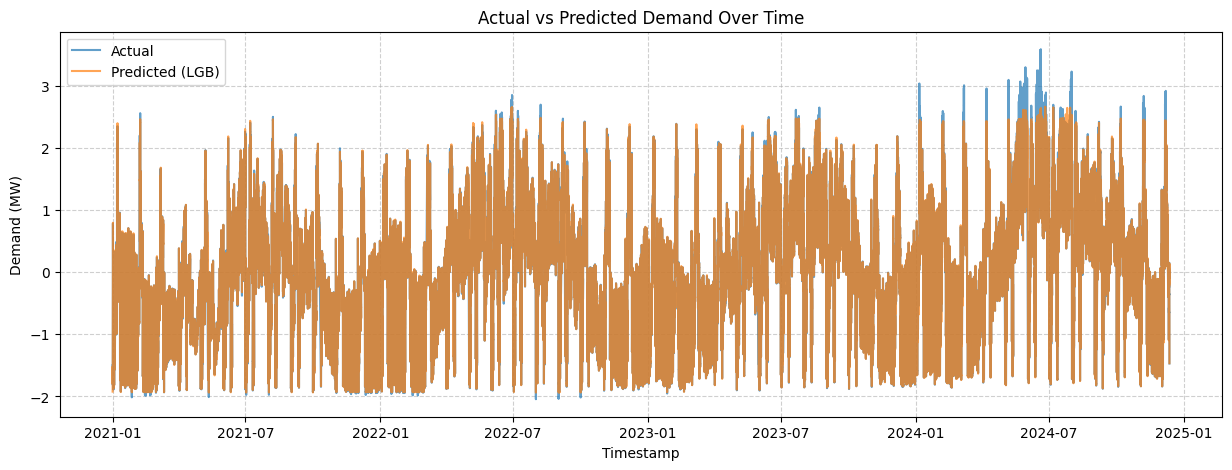

In [13]:
# --- 1. Actual vs Predicted plot ---
plt.figure(figsize=(15,5))
# This line will now work as 'timestamp' is a regular column
plt.plot(electricity['timestamp'], electricity['demand_mw'], label='Actual', alpha=0.7) 
plt.plot(electricity['timestamp'], pred_lgb_test[:len(electricity)], label='Predicted (LGB)', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Demand (MW)')
plt.title('Actual vs Predicted Demand Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


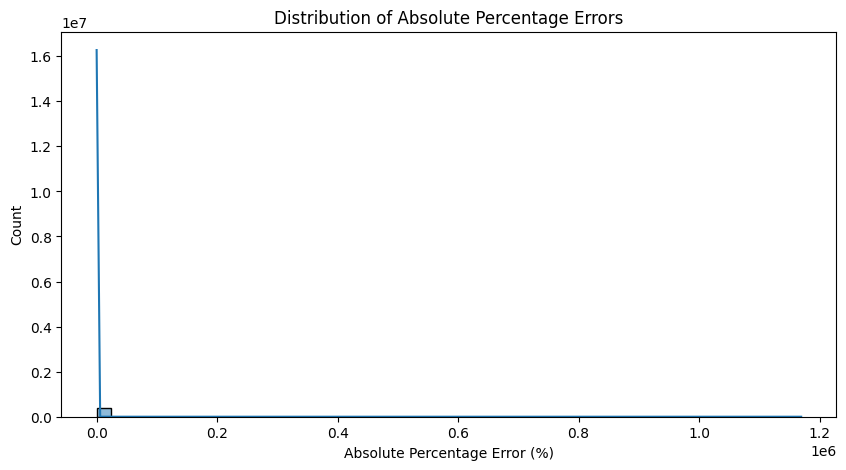

In [14]:
# --- 2. Error distribution plot ---
plt.figure(figsize=(10,5))
# abs_perc_error was calculated and should still be in memory
sns.histplot(electricity['abs_perc_error'], bins=50, kde=True) 
plt.xlabel('Absolute Percentage Error (%)')
plt.title('Distribution of Absolute Percentage Errors')
plt.show()

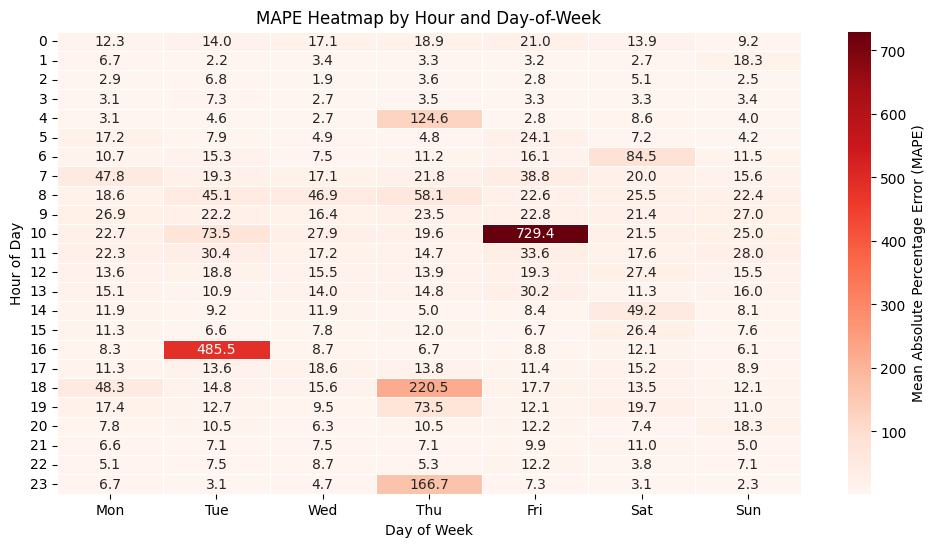

In [68]:
abs_perc_error = np.abs((electricity['demand_mw'].values - pred_lgb_test[:len(electricity)]) / electricity['demand_mw'].values) * 100
electricity['abs_perc_error'] = abs_perc_error

if 'day_of_week' not in electricity.columns:
    electricity['day_of_week'] = electricity['timestamp'].dt.dayofweek.astype(int) # 0=Mon, 6=Sun

heatmap_data = electricity.groupby(['hour_of_day', 'day_of_week'])['abs_perc_error'].mean().unstack()
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    cmap='Reds', # Use a red color scale for error intensity
    annot=True, 
    fmt=".1f", # Show 1 decimal place (the Mean MAPE)
    linewidths=0.5,
    cbar_kws={'label': 'Mean Absolute Percentage Error (MAPE)'}
)
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.title('MAPE Heatmap by Hour and Day-of-Week')
plt.xticks(ticks=np.arange(len(day_labels)) + 0.5, labels=day_labels)
plt.yticks(rotation=0)
plt.show()

electricity.drop(columns=['abs_perc_error'], inplace=True, errors='ignore')

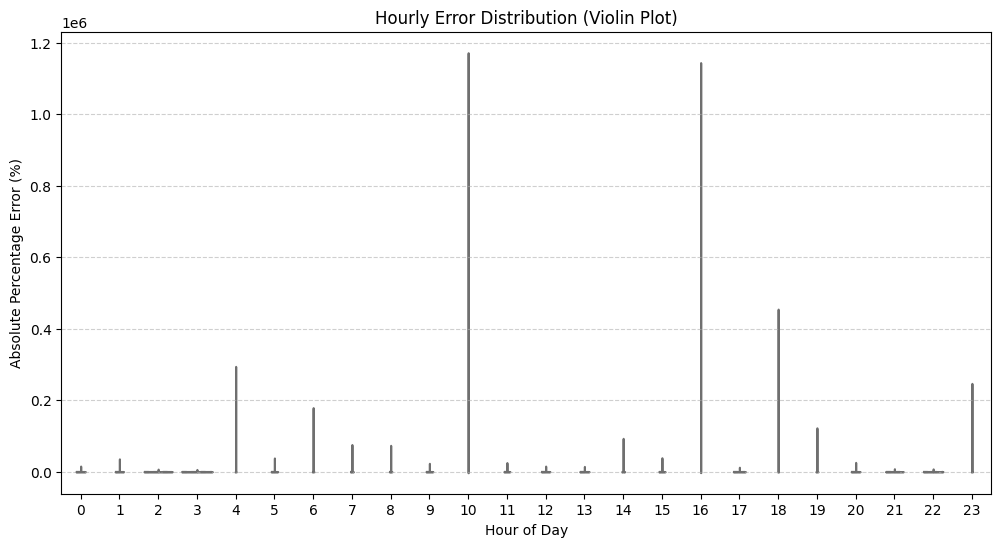

In [72]:
plt.figure(figsize=(12, 6))
# Using a violin plot 
sns.violinplot(
    x='hour_of_day', 
    y='abs_perc_error', 
    data=electricity, 
    inner='quartile', # Displays the quartiles inside the violin
    color='skyblue'
)
plt.xlabel('Hour of Day')
plt.ylabel('Absolute Percentage Error (%)')
plt.title('Hourly Error Distribution (Violin Plot)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()